### Author: Boris Kundu ###

### Problem Statement ###

* Create job recommendation engine that recommend similar jobs based on the job title and description.
* Create job recommendation engine that recommends jobs to a user by matching profile with other users and suggest jobs applied by them.

### Dataset ###
https://www.kaggle.com/c/job-recommendation/data?select=jobs.zip

### Solution Outline ###
• We can solve both these problems by using NLP techniques such as memory-based collaborative filtering (cosine similarity) to identify matching jobs.

• When a user shows interest in a job, we can get his/her preferred job title (role) to match jobs with similar titles posted by recruiters.

• When a user provides details such as Summary, Experience, Certifications, Skills etc. we can combine these to form a user profile and then find relevant jobs by matching his resume with job descriptions from posted jobs. 

• For the user, the corpus will include all job details posted/present in the system. User’s preferred roles and resume will be matched against all job details.

• The same approach can be used by recruiter to find job seekers whose preferred/current job role matches with the job title that he/she is posting. Also, their job description will be matched against all user profiles available on the system

• For the recruiter, the corpus will include all user profiles present in the system. Recruiter’s job details will be matched against all user profiles.

• Just like we watched a user profile to all job profiles, we can also match user with other user profiles.

• After we find similar users, we can then look at the job they have applied (wisdom of others) to and suggest those jobs to our current user.

### 1. Setup libraries ###
1. Install packages
2. Import packages
3. Download other libraries (as needed)

In [250]:
# Install packages - Uncomment to install

#!pip install --upgrade pip
#!pip install pandas
#!pip install numpy

#!pip install nltk

#!pip install spacy

#!pip install sklearn

import string
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')

from spacy.lang.en.stop_words import STOP_WORDS

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
#from sklearn.model_selection import GridSearchCV

### 2. Data loading ###

In [251]:
jobs = pd.read_csv('./data/jobs.tsv', delimiter='\t',encoding='utf-8', error_bad_lines=False)
apps = pd.read_csv('./data/apps.tsv', delimiter='\t',encoding='utf-8')
users = pd.read_csv('./data/users.tsv' ,delimiter='\t',encoding='utf-8')

b'Skipping line 122433: expected 11 fields, saw 12\n'
b'Skipping line 602576: expected 11 fields, saw 12\n'
b'Skipping line 990950: expected 11 fields, saw 12\n'


In [252]:
# Check jobs
jobs.info()
jobs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091923 entries, 0 to 1091922
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   JobID         1091923 non-null  int64 
 1   WindowID      1091923 non-null  int64 
 2   Title         1091916 non-null  object
 3   Description   1091913 non-null  object
 4   Requirements  1050521 non-null  object
 5   City          1091921 non-null  object
 6   State         1091922 non-null  object
 7   Country       1091920 non-null  object
 8   Zip5          685724 non-null   object
 9   StartDate     1091923 non-null  object
 10  EndDate       1091914 non-null  object
dtypes: int64(2), object(9)
memory usage: 91.6+ MB


,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


In [253]:
# Check users
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389708 entries, 0 to 389707
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   UserID                389708 non-null  int64  
 1   WindowID              389708 non-null  int64  
 2   Split                 389708 non-null  object 
 3   City                  389708 non-null  object 
 4   State                 389218 non-null  object 
 5   Country               389708 non-null  object 
 6   ZipCode               387974 non-null  object 
 7   DegreeType            389708 non-null  object 
 8   Major                 292468 non-null  object 
 9   GraduationDate        269477 non-null  object 
 10  WorkHistoryCount      389708 non-null  int64  
 11  TotalYearsExperience  375528 non-null  float64
 12  CurrentlyEmployed     347632 non-null  object 
 13  ManagedOthers         389708 non-null  object 
 14  ManagedHowMany        389708 non-null  int64  
dtype

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [254]:
# Check applications
apps.info()
apps.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603111 entries, 0 to 1603110
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   UserID           1603111 non-null  int64 
 1   WindowID         1603111 non-null  int64 
 2   Split            1603111 non-null  object
 3   ApplicationDate  1603111 non-null  object
 4   JobID            1603111 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 61.2+ MB


,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


## 3. Exploratory Data Analysis

In [255]:
# Plot jobs by state
def plot_jobs(df,feature):
    jobs_by_state = df.groupby([feature]).size().reset_index(name= 'Count').sort_values('Count',ascending=False)
    plt.figure(figsize=(12,12))
    ax = sns.barplot(x=feature, y="Count",data=jobs_by_state)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
    ax.set_title(f'Jobs by {feature}')
    plt.tight_layout()
    plt.show()

In [256]:
# Check for null values
jobs.isna().sum()

JobID                0
WindowID             0
Title                7
Description         10
Requirements     41402
City                 2
State                1
Country              3
Zip5            406199
StartDate            0
EndDate              9
dtype: int64

In [257]:
# Check for null values
apps.isna().sum()

UserID             0
WindowID           0
Split              0
ApplicationDate    0
JobID              0
dtype: int64

In [258]:
# Check for null values
users.isna().sum()

UserID                       0
WindowID                     0
Split                        0
City                         0
State                      490
Country                      0
ZipCode                   1734
DegreeType                   0
Major                    97240
GraduationDate          120231
WorkHistoryCount             0
TotalYearsExperience     14180
CurrentlyEmployed        42076
ManagedOthers                0
ManagedHowMany               0
dtype: int64

In [259]:
# Remove jobs without title or description
jobs = jobs.dropna(subset=['Title', 'Description'])
# Remove users without major or total years of experience
users = users.dropna(subset = ['Major','TotalYearsExperience'])

In [260]:
# Drop unwanted fields
jobs.drop(['Zip5','WindowID', 'Requirements','StartDate','EndDate'], axis = 1, inplace=True)
users.drop(['ZipCode','WindowID', 'Split','GraduationDate'], axis = 1, inplace=True)
apps.drop(['Split','WindowID'], axis = 1, inplace=True)

In [261]:
# Lets focus on US jobs, users, and applications only for now
jobs = jobs.loc[jobs['Country'] == 'US']
users = users.loc[users['Country'] == 'US']
ids = apps.UserID.isin(users.UserID) & apps.JobID.isin(jobs.JobID)
apps = apps[ids]

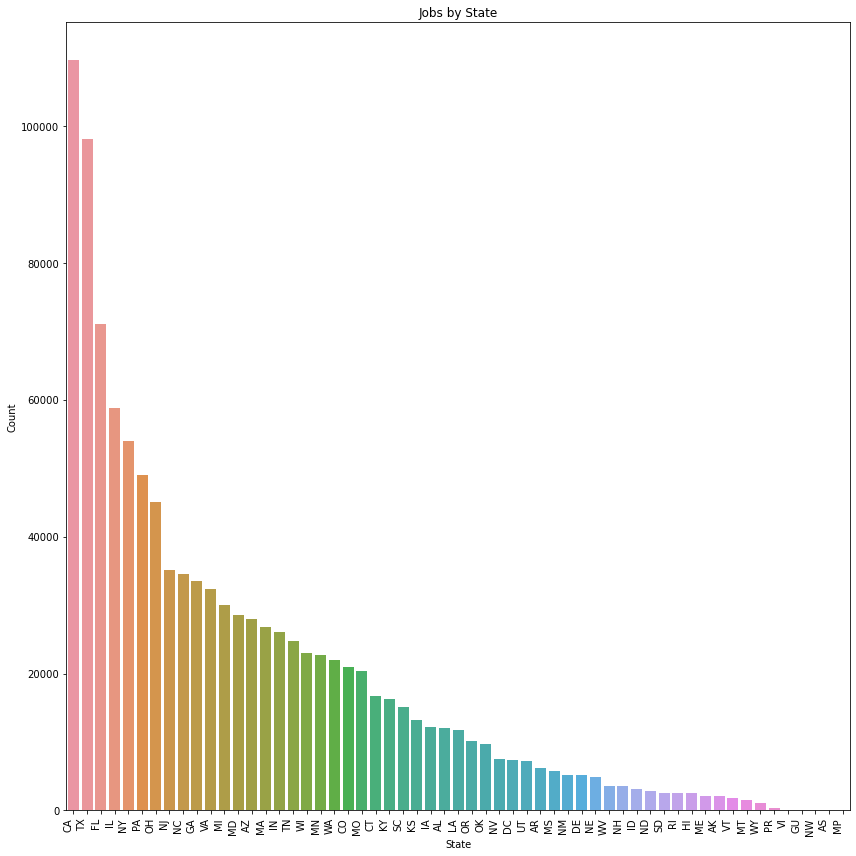

In [262]:
# Check jobs by state
plot_jobs(jobs,'State')

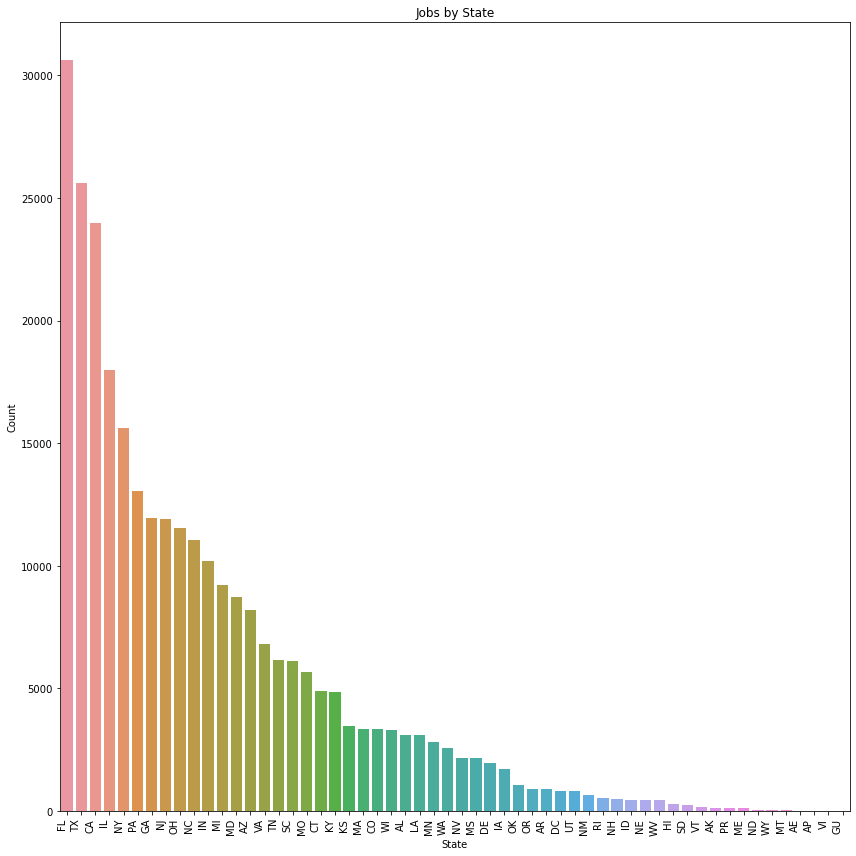

In [263]:
# Check users by state
plot_jobs(users,'State')

### 3. Data pre-processing ###

1. Clean data (punctuations, white spaces etc.)
2. Tokenize text
3. Remove stopwords
4. Lemmatize text
5. Filter unwanted Part of Speech

In [264]:
# Corpus specific stop words
custom_stop_words = [] #['opportunity', 'job', 'opening']
# POS filtering NOUN, VERB, ADJECTIVE, PROVERB
allowed_tags = ['NN','NNP','NNPS','NNS',
                'VB','VBD','VBG','VBN','VBP','VBZ',
                'JJ','JJR', 'JJS', 
                'RB', 'RBR', 'RBS']

In [265]:
# Remove punctuations
def remove_punctuation(text):
    for punc in string.punctuation:
        text = text.replace(punc, ' ')
    return text

In [266]:
# Remove noise
def clean(dataset, sections = []):
    if not sections:
        sections = [col for col in dataset.columns if dataset[col].dtype == object]
    # Replace any [],().{}
    dataset = dataset.replace(r'[\([{})\]]', ' ', regex = True)
    for sec in sections:
        # Remove numbers
        dataset[sec] = dataset[sec].str.replace(r'\d+', ' ', regex = True)
        # Lowercase text
        dataset[sec] = dataset[sec].str.lower()
        # Remove tags like <tab>
        dataset[sec] = dataset[sec].str.replace(r'<[^<>]*>', ' ', regex = True)
        # Remove standalone sequences of specials like &#
        dataset[sec] = dataset[sec].str.replace(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', regex = True)
        # Remove standalone sequences of hyphens like — or ==
        dataset[sec] = dataset[sec].str.replace('—', ' ')
        # Remove new line chaarcters '\n'
        dataset[sec] = dataset[sec].str.replace('\n',' ')
        # Remove any backslash 
        dataset[sec] = dataset[sec].str.replace(r'\\', ' ')
        # Remove any forward slash
        dataset[sec] = dataset[sec].str.replace(r'//', ' ')
        # Remove punctuations
        dataset[sec] = dataset[sec].apply(remove_punctuation)
        # Remove single characters
        dataset[sec] = dataset[sec].str.replace(r'\b\w\b', ' ', regex = True)
        # Remove sequence of white spaces
        dataset[sec] = dataset[sec].str.replace(r'\s+', ' ', regex = True)
        # Remove any leading or trailing white spaces
        dataset[sec] = dataset[sec].str.strip()
    return dataset

In [267]:
# Get all stop words
def get_stop_words(custom_stop_words):
    stop_words = STOP_WORDS.union(set(stopwords.words('english')))
    stop_words = stop_words.union(set(custom_stop_words))
    return stop_words

In [268]:
# Create doc/sentence from tokens/words/lemmas
def word2doc(words):
    text_out = ' '.join(words)
    return text_out

In [269]:
# Tokenize text
def tokenize_text(text):
    stop_words = get_stop_words(custom_stop_words)
    tokens = [token for token in nltk.tokenize.word_tokenize(text) if token not in stop_words]
    return tokens

In [270]:
# Filter words that are not NOUN, VERB, ADJECTIVE, PROVERB
def lemmatize_pos_filtering(words):
    stop_words = get_stop_words(custom_stop_words)
    wordnet_lemmatizer = WordNetLemmatizer()
    filtered_words = []
    for word in words:
        tag = nltk.pos_tag([word])[0][1]
        if tag in allowed_tags:
            tag = tag[0].lower()
            if tag == 'j':
                tag = 'a'
            else:
                tag = tag if tag in ['r', 'n', 'v'] else None
            if not tag:
                lemma = word
            else:
                lemma = wordnet_lemmatizer.lemmatize(word, tag)
            if lemma not in stop_words:
                filtered_words.append(lemma)
    return filtered_words

In [271]:
# Prepare data
def prepare_data(df, input_feature, out_feature):
    # Get tokens
    df[out_feature + '_Tokens'] = df[input_feature].apply(tokenize_text)
    # Get POS filtered words
    df[out_feature + '_Lemmas'] = df[out_feature + '_Tokens'].apply(lemmatize_pos_filtering)
    # Get POS filtered text
    df[out_feature] = df[out_feature + '_Lemmas'].apply(word2doc)
    return df

In [272]:
# Lets take 5k jobs for now
jobs_1K = jobs.iloc[0:5000]

In [273]:
# Lets take 5k users for now
users_1K = users.iloc[0:5000]

In [274]:
# Clean job data
jobs_1K = clean(jobs_1K)

In [275]:
# Check info
jobs_1K.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 5002
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   JobID        5000 non-null   int64 
 1   Title        5000 non-null   object
 2   Description  5000 non-null   object
 3   City         5000 non-null   object
 4   State        5000 non-null   object
 5   Country      5000 non-null   object
dtypes: int64(1), object(5)
memory usage: 273.4+ KB


In [276]:
# Prepare job description
jobs_1K = prepare_data(jobs_1K, 'Description', 'Prepared_Description')

In [277]:
# Prepare job title
jobs_1K = prepare_data(jobs_1K, 'Title', 'Prepared_Title')

In [278]:
# Check head
jobs_1K.T.head(20)

,0,1,2,3,4,5,6,7,8,9,...,4993,4994,4995,4996,4997,4998,4999,5000,5001,5002
JobID,1,4,7,8,9,10,11,12,13,14,...,18626,18627,18628,18630,18631,18632,18633,18634,18635,18636
Title,security engineer technical lead,sap business analyst wm,human resources assistant,route delivery drivers,housekeeping,salon spa coordinator,superintendent,electronic pre press professional,utility line truck operator digger derrick,construction project mgr pm trainee,...,bilingual recruiter,business analyst,broadcast planning engineer satellite capacity,finance manager of mm division,senior tax compliance associate,senior auditor,systems integration analyst ca,dncs test engineer,staff accountant,corporate accountant
Description,security clearance required nbsp top secret jo...,no corp to corp resumes nbsp are being conside...,human resources assistant years experience in ...,city beverages come to work for the best in th...,make sure every part of their day is magical a...,salon spa coordinator daytona college in ormon...,superintendent central florida general contrac...,electronic pre press professional for comm she...,utility line truck operator digger derrick ope...,construction project mgr pm trainee commercial...,...,responsibilities our client located in arlingt...,responsibilities our client located in new yor...,responsibilities the selected engineer will al...,responsibilities this is great opportunity for...,responsibilities our client leading westcheste...,responsibilities our client leading fairfield ...,responsibilities perform system design develop...,responsibilities be part of our client high en...,responsibilities our juno beach florida client...,responsibilities this role has responsibility ...
City,washington,charlotte,winter park,orlando,orlando,ormond beach,orlando,orlando,orlando,winter park,...,arlington,new york,el segundo,irving,purchase,greenwich,boston,lawrenceville,north palm beach,boston
State,dc,nc,fl,fl,fl,fl,fl,fl,fl,fl,...,tx,ny,ca,tx,ny,ct,ma,ga,fl,ma
Country,us,us,us,us,us,us,us,us,us,us,...,us,us,us,us,us,us,us,us,us,us
Prepared_Description_Tokens,"[security, clearance, required, nbsp, secret, ...","[corp, corp, resumes, nbsp, considered, ldquo,...","[human, resources, assistant, years, experienc...","[city, beverages, come, work, best, business, ...","[sure, day, magical, disney, dreams, find, wal...","[salon, spa, coordinator, daytona, college, or...","[superintendent, central, florida, general, co...","[electronic, pre, press, professional, comm, s...","[utility, line, truck, operator, digger, derri...","[construction, project, mgr, pm, trainee, comm...",...,"[responsibilities, client, located, arlington,...","[responsibilities, client, located, new, york,...","[responsibilities, selected, engineer, allocat...","[responsibilities, great, opportunity, finance...","[responsibilities, client, leading, westcheste...","[responsibilities, client, leading, fairfield,...","[responsibilities, perform, system, design, de...","[responsibilities, client, high, energy, syste...","[responsibilities, juno, beach, florida, clien...","[responsibilities, role, responsibility, gener..."
Prepared_Description_Lemmas,"[security, clearance, require, nbsp, secret, j...","[corp, corp, resume, nbsp, consider, ldquo, di...","[human, resource, assistant, year, experience,...","[city, beverage, come, work, best, business, c...","[sure, day, magical, disney, dream, find, walt...","[salon, spa, coordinator, daytona, college, or...","[superintendent, central, florida, general, co...","[electronic, pre, press, professional, comm, s...","[utility, line, truck, operator, digger, derri...","[construction, project, mgr, pm, trainee, comm...",...,"[responsibility, client, locate, arlington, te...","[responsibility, client, locate, new, york, ne...","[responsibility, select, engineer, allocate, s...","[responsibility, great, opportunity, finance, ...","[responsibility, client, lead, westchester, co...","[responsibility, client, lead, fairfield, coun..."

### 5. Modeling ###

1. Hyperparameter tuning (skip)
2. Get best model with parameters (skip)
3. Define tfidf parameters based on requirement

# Define pipeline
pipeline = Pipeline([('tfidf', TfidfVectorizer())])
# Define params
params = {
            'tfidf__max_df': [0.4,0.5,0.6],
            'tfidf__min_df': [10,20,20],
            'tfidf__ngram_range': [(1,1), (1,2), (2,2), (2,3), (3,3)]
            }

# Perform hyperparameter tuning
def hyperparameter_tuning(pipeline, params, data, jobs = 4):
    # Init Grid Search Class
    model = GridSearchCV(estimator = pipeline, param_grid = params, n_jobs = jobs, return_train_score=True)
    # Do the Grid Search
    model.fit(data)
    # Best Model
    best_estimator = model.best_estimator_
    # Model Parameters
    print("Best Params: ", model.best_params_)
    # Score
    print("Best Score: ", model.best_score_)
    return (best_estimator)

# Get best model for description
best_desc_model = hyperparameter_tuning(pipeline, params, jobs_1K['Prepared_Description'], jobs = 4)

# Get best model for title
best_title_model = hyperparameter_tuning(pipeline, params, jobs_1K['Prepared_Title'], jobs = 4)

In [279]:
# Get vector model for description
# Only do transform after getting best model. No need to fit again.
#tf_desc = best_desc_model.named_steps['tfidf']

# Define params
tf_desc = TfidfVectorizer(max_df = 0.5, min_df = 10, ngram_range = (2,3))
# Vectorize description
tfidf_desc_data = tf_desc.fit_transform(jobs_1K['Prepared_Description'])

In [280]:
# Get vector model for description
# Only do transform after getting best model. No need to fit again.
#tf_title = best_title_model.named_steps['tfidf']

# Define params
tf_title = TfidfVectorizer(max_df = 0.8, ngram_range = (1,2))
# Vectorize description
tfidf_title_data = tf_title.fit_transform(jobs_1K['Prepared_Title'])

### 6.	Predictions ###
1. Find jobs by matching titles with user's preferred/current role
2. Find jobs by mtaching descrpition with user profile/resume content

In [281]:
# Recommend jobs
def get_top_jobs(dataset, search_title, top_matches = 5, vector_model = tf_title, vector_data = tfidf_title_data):
    # Create dataframe from search condition
    df = pd.DataFrame([search_title])
    df.columns = ['Search Query']
    # Clean text
    df = clean(df)
    # Prepare search query
    df = prepare_data(df, 'Search Query', 'Prepared Query')
    # Vectorize input
    vector_input = vector_model.transform(df['Prepared Query'])
    # Get similarity score
    sim = cosine_similarity(vector_input, vector_data)
    # Get matching jobs
    matching_jobs = dataset.iloc[np.argsort(sim[0])[::-1][0:top_matches]][["JobID", "Title", "Description"]]
    return matching_jobs

## By Title for matching preferred/current role

In [282]:
# Test 1 by Title (user's preferred/current role)
search_query = 'Software Developer'

best_matches = get_top_jobs(jobs_1K, search_query, 5, tf_title, tfidf_title_data)
best_matches.head(5)

,JobID,Title,Description
2198,8766,software developer,global science amp technology inc fast growing...
3755,15074,software developer,job summary provide programming support around...
815,2962,software developer,liberty mutual insurance “helping people live ...
4641,18179,software developer,responsibilities this position is responsible ...
3497,13993,software developer,software developer immediate need for very tal...


In [283]:
# Test 2 by Title (user's preferred/current role)
search_query = 'Business Analyst'

best_matches = get_top_jobs(jobs_1K, search_query, 10, tf_title, tfidf_title_data)
best_matches.head(10)

,JobID,Title,Description
99,264,business analyst,we don just see the value of our performance w...
2983,12141,business analyst,develop prepare and distribute business requir...
3960,15814,business analyst,salary range nbsp nbsp nbsp nbsp nbsp marketin...
4816,18396,business analyst,responsibilities this person will be responsib...
4644,18185,business analyst,responsibilities business analyst responsibili...
1019,3505,business analyst,overview under direct supervision and with ass...
4994,18627,business analyst,responsibilities our client located in new yor...
4923,18535,business analyst,responsibilities our honolulu hawaii client is...
4702,18257,business analyst,responsibilities business analyst responsibili...
4136,16445,it business analyst,ep henry corporation recognized industry leade...


## By Description for matching resume/profile content

In [284]:
# Test 3 by Description (user's resume/profile content)
search_query = "Developed, maintained, and documented solutions for different client's user interface and inventory management systems by leveraging industry best practices, development tools, programming, and web engineering languages (Java, PL-SQL, SQL, Shell, Unix, ANT, Gradle, JSP, HTML, JS, MVC, SOAP, REST, SONAR, JUnit, Oracle, SVN). Modeled network inventory data and metadata, performed product upgrades, merged and migrated data for different clients."

best_matches = get_top_jobs(jobs_1K, search_query, 5, tf_desc, tfidf_desc_data)
best_matches.head(5)

,JobID,Title,Description
4187,16665,unix linux system administrator,ringles markets is currently seeking motivated...
3176,12789,java web developer with ajax json development ...,security clearance public trust experience dev...
3280,13167,mgr lean enterprise,bae systems is premier global defense and secu...
3148,12760,software engineer,security clearance secret • demonstrated stron...
4633,18164,network administrator,responsibilities our client is looking for net...


## By User matching with others

In [285]:
# Create user profiles
def create_user_profiles(df):
    # Prepare profile
    df['Profile'] = df['DegreeType'] + ' ' + df['Major'] # Add summary, experiences, skills etc.
    # Clean text
    df = clean(df,['Profile'])
    return df

In [286]:
# Calculcate user profile similarity scores
def calculate_profile_similarity_scores(dataset, feature):
    # Vectorize user data
    tf_users = TfidfVectorizer(ngram_range=(1, 2))
    tfidf_users = tf_users.fit_transform(dataset[feature])
    # Get similarity scores between users
    cosine_sim = linear_kernel(tfidf_users, tfidf_users)
    return cosine_sim

In [287]:
# Get top macthing users
def get_top_users(userid, similarity_scores, indices, top = 5):
    idx = indices[userid]
    sim_scores = list(enumerate(similarity_scores[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    user_indices = [i[0] for i in sim_scores]
    print(f' Top {top} similar users to user <{userid}> are:\n {user_indices[:top]}')
    return user_indices[:top]

In [298]:
# Get jobs applied by users
def get_user_applied_jobs(userids):
    user_job_applications = apps['UserID'].isin(userids)
    applied_jobs = pd.DataFrame(data = apps[user_job_applications], columns=['JobID'])
    job_list = applied_jobs['JobID'].tolist()
    user_jobs = jobs['JobID'].isin(job_list)
    jobs_temp = pd.DataFrame(data = jobs[user_jobs], columns=['JobID','Title','Description'])
    return jobs_temp

In [299]:
# Create profiles
users_1K = create_user_profiles(users_1K)

In [300]:
# Get similarity scores
similarity_scores = calculate_profile_similarity_scores(users_1K,'Profile')

In [301]:
# Get user indices
indices = pd.Series(users_1K.index, index=users_1K['UserID'])

In [305]:
# Get jobs applied by matching user
similar_user_applied_jobs = get_user_applied_jobs(get_top_users(123,similarity_scores,indices,5))
similar_user_applied_jobs.head(10)

 Top 5 similar users to user <123> are:
 [4, 348, 389, 420, 559]


,JobID,Title,Description
741959,167313,Sales Assistant,<strong>Classification: </strong> Secretary/A...
755609,280681,Customer Service Representative,Top&nbsp;financial service institution is seek...
757753,296442,Residential Real Estate Junior Paralegal,<p>Large distinguished company is seeking an e...
762615,334051,Management,"<p style=""text-align: center"" align=""center""><..."
776835,444126,Part Time Marketing Administrative Assistant,"<span><strong>At Olsten, we have been matching..."
783875,500312,Data Entry Clerk,"<strong><span style=""text-decoration: underlin..."
799727,628283,Inside Phone Sales and Outside Sales Associate...,"<P>TelNet, an ambitious Charlotte based B2B te..."
803854,662253,Recruiting Assistant,<p><b><span>SUMMARY:&nbsp; </span></b></p>\r<p...
808706,699271,Patient Scheduling Representative,"<p>At <strong>University Dental Associates, Ra..."
849601,1021171,Human Resources Assistant,<strong>Classification: </strong> Personnel/H...
